# Momentum

In the ["Gradient Descent and Stochastic Gradient Descent"](./gd-sgd.md) section, we mentioned that the gradient of the objective function's independent variable represents the direction of the objective function's fastest descend at the current position of the independent variable. Therefore, gradient descent is also called steepest descent. In each iteration, the gradient descends according to the current position of the independent variable while updating the latter along the current position of the gradient. However, this can lead to problems if the iterative direction of the independent variable relies exclusively on the current position of the independent variable.


## Exercises with Gradient Descent

Now, we will consider an objective function $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$, whose input and output are a two-dimensional vector $\boldsymbol{x} = [x_1, x_2]$ and a scalar, respectively. In contrast to the ["Gradient Descent and Stochastic Gradient Descent"](./gd-sgd.md) section, here, the coefficient $x_1^2$ is reduced from $1$ to $0.1$. We are going to implement gradient descent based on this objective function, and demonstrate the iterative trajectory of the independent variable using the learning rate $0.4$.

epoch 20, x1 -0.943467, x2 -0.000073


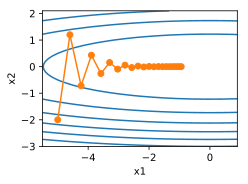

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
from mxnet import nd

eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

As we can see, at the same position, the slope of the objective function has a larger absolute value in the vertical direction ($x_2$ axis direction) than in the horizontal direction ($x_1$ axis direction). Therefore, given the learning rate, using gradient descent for interaction will cause the independent variable to move more in the vertical direction than in the horizontal one. So we need a small learning rate to prevent the independent variable from overshooting the optimal solution for the objective function in the vertical direction. However, it will cause the independent variable to move slower toward the optimal solution in the horizontal direction.

Now, we try to make the learning rate slightly larger, so the independent variable will continuously overshoot the optimal solution in the vertical direction and gradually diverge.

epoch 20, x1 -0.387814, x2 -1673.365109


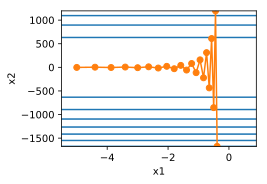

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

## The Momentum Method

The momentum method was proposed to solve the gradient descent problem described above. Since mini-batch stochastic gradient descent is more general than gradient descent, the subsequent discussion in this chapter will continue to use the definition for mini-batch stochastic gradient descent $\boldsymbol{g}_t$ at time step $t$ given in the ["Mini-batch Stochastic Gradient Descent"](minibatch-sgd.md) section. We set the independent variable at time step $t$ to $\boldsymbol{x}_t$ and the learning rate to $\eta_t$.
At time step $0$, momentum creates the velocity variable $\boldsymbol{v}_0$ and initializes its elements to zero. At time step $t>0$, momentum modifies the steps of each iteration as follows:

$$
\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}
$$

Here, the momentum hyperparameter $\gamma$ satisfies $0 \leq \gamma < 1$. When $\gamma=0$, momentum is equivalent to a mini-batch SGD.

Before explaining the mathematical principles behind the momentum method, we should take a look at the iterative trajectory of the gradient descent after using momentum in the experiment.

epoch 20, x1 -0.062843, x2 0.001202


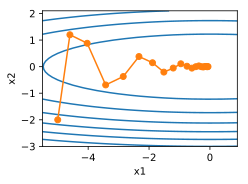

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

As we can see, when using a smaller learning rate ($\eta=0.4$) and momentum hyperparameter ($\gamma=0.5$), momentum moves more smoothly in the vertical direction and approaches the optimal solution faster in the horizontal direction. Now, when we use a larger learning rate ($\eta=0.6$), the independent variable will no longer diverge.

epoch 20, x1 0.007188, x2 0.002553


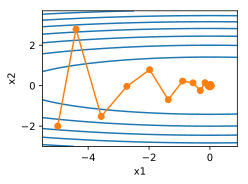

In [4]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### Exponentially Weighted Moving Average (EWMA)

In order to understand the momentum method mathematically, we must first explain the exponentially weighted moving average (EWMA). Given hyperparameter $0 \leq \gamma < 1$, the variable $y_t$ of the current time step $t$ is the linear combination of variable $y_{t-1}$ from the previous time step $t-1$ and another variable $x_t$ of the current step.

$$y_t = \gamma y_{t-1} + (1-\gamma) x_t.$$

We can expand $y_t$:

$$
\begin{aligned}
y_t  &= (1-\gamma) x_t + \gamma y_{t-1}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\
         &\ldots
\end{aligned}
$$

Let $n = 1/(1-\gamma)$, so $\left(1-1/n\right)^n = \gamma^{1/(1-\gamma)}$. Because

$$ \lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,$$

when $\gamma \rightarrow 1$, $\gamma^{1/(1-\gamma)}=\exp(-1)$. For example, $0.95^{20} \approx \exp(-1)$. If we treat $\exp(-1)$ as a relatively small number, we can ignore all the terms that have $\gamma^{1/(1-\gamma)}$ or coefficients of higher order than $\gamma^{1/(1-\gamma)}$ in them. For example, when $\gamma=0.95$,

$$y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.$$

Therefore, in practice, we often treat $y_t$ as the weighted average of the $x_t$ values from the last $1/(1-\gamma)$ time steps. For example, when $\gamma = 0.95$, $y_t$ can be treated as the weighted average of the $x_t$ values from the last 20 time steps; when $\gamma = 0.9$, $y_t$ can be treated as the weighted average of the $x_t$ values from the last 10 time steps. Additionally, the closer the $x_t$ value is to the current time step $t$, the greater the value's weight (closer to 1).


### Understanding Momentum through EWMA

Now, we are going to deform the velocity variable of momentum:

$$\boldsymbol{v}_t \leftarrow \gamma \boldsymbol{v}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{g}_t\right). $$

By the form of EWMA, velocity variable $\boldsymbol{v}_t$ is actually an EWMA of time series $\{\eta_{t-i}\boldsymbol{g}_{t-i} /(1-\gamma):i=0,\ldots,1/(1-\gamma)-1\}$. In other words, considering mini-batch SGD, the update of an independent variable with momentum at each time step approximates the EWMA of the updates in the last $1/(1-\gamma)$ time steps without momentum, divided by $1-\gamma$. Thus, with momentum, the movement size at each direction not only depends on the current gradient, but also depends on whether the past gradients are aligned at each direction. In the optimization problem mentioned earlier in this section, all the gradients are positive in the horizontal direction (rightward), but are occasionally positive (up) or negative (down) in the vertical direction. As a result, we can use a larger learning rate to allow the independent variable move faster towards the optimum.

## Implementation from Scratch

Compared with mini-batch SGD, the momentum method needs to maintain a velocity variable of the same shape for each independent variable and a momentum hyperparameter is added to the hyperparameter category. In the implementation, we use the state variable `states` to represent the velocity variable in a more general sense.

In [5]:
features, labels = d2l.get_data_ch7()

def init_momentum_states():
    v_w = nd.zeros((features.shape[1], 1))
    v_b = nd.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v[:] = hyperparams['momentum'] * v + hyperparams['lr'] * p.grad
        p[:] -= v

When we set the momentum hyperparameter `momentum` to 0.5, it can be treated as a mini-batch SGD: the mini-batch gradient here is the weighted average of twice the mini-batch gradient of the last two time steps.

loss: 0.242827, 0.238280 sec per epoch


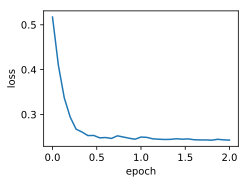

In [6]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
             {'lr': 0.02, 'momentum': 0.5}, features, labels)

When we increase the momentum hyperparameter `momentum` to 0.9, it can still be treated as a mini-batch SGD: the mini-batch gradient here will be the weighted average of ten times the mini-batch gradient of the last 10 time steps. Now we keep the learning rate at 0.02.

loss: 0.254285, 0.232459 sec per epoch


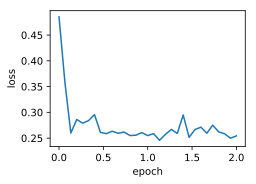

In [7]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

We can see that the value change of the objective function is not smooth enough at later stages of iteration. Intuitively, ten times the mini-batch gradient is five times larger than two times the mini-batch gradient, so we can try to reduce the learning rate to 1/5 of its original value. Now, the value change of the objective function becomes smoother after its period of decline.

loss: 0.243686, 0.233135 sec per epoch


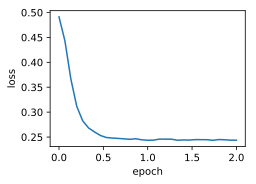

In [8]:
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.004, 'momentum': 0.9}, features, labels)

## Concise Implementation

In Gluon, we only need to use `momentum` to define the momentum hyperparameter in the `Trainer` instance to implement momentum.

loss: 0.246800, 0.191183 sec per epoch


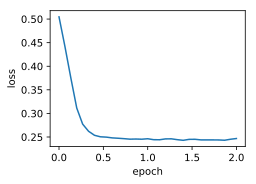

In [9]:
d2l.train_gluon_ch7('sgd', {'learning_rate': 0.004, 'momentum': 0.9},
                    features, labels)

## Summary

* The momentum method uses the EWMA concept. It takes the weighted average of past time steps, with weights that decay exponentially by the time step.
* Momentum makes independent variable updates for adjacent time steps more consistent in direction.

## Exercises

* Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2374)

![](../img/qr_momentum.svg)